# Inisiasi Awal

In [ ]:
!pip install tensorflow transformers nltk

In [53]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re, string, unicodedata
import seaborn as sns
import tensorflow as tf
import pandas as pd

from keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, GRU, Input, Layer, LSTM, BatchNormalization, LayerNormalization
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.src.layers.core.activation import activations
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from transformers import AlbertTokenizer, TFAutoModel

In [55]:
!wget https://nlp.stanford.edu/data/glove.6B.zip --no-check-certificate

--2024-06-14 11:23:08--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-14 11:23:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-06-14 11:25:47 (5.17 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [56]:
!unzip /kaggle/working/glove.6B.zip

Archive:  /kaggle/working/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


# Load Dataset

In [1]:
tempo_path = '/kaggle/input/converted-news/tempo.csv'
tbh_path = '/kaggle/input/converted-news/turnbackhoax.csv'
kompas_path ='/kaggle/input/converted-news/kompas.csv/'
cnn_path ='/kaggle/input/converted-news/cnn.csv/'


In [15]:
def excel_to_df(path):
    df = pd.read_excel(path)
    return df

In [4]:
#Non-HOAX
df_tempo = pd.read_csv(tempo_path)
#add dataset
df_cnn = pd.read_csv(cnn_path)
df_kompas = pd.read_csv(kompas_path)


#HOAX
df_tbh = pd.read_csv(tbh_path)

In [5]:
df_tempo

,title,raw timestamp,original,tags,author,url,cleaned,label,timestamp,cleaned token length,summarized
0,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,"Sabtu, 1 Januari 2022 17:14 WIB","TEMPO.CO, Jakarta - Wakil Presiden Ma'ruf Amin...",Ma'ruf Amin;Piala AFF 2020;Indonesia vs Thaila...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545504/maruf-a...,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,0,2022-01-01 17:14:00,41,Timnas Indonesia Vs Thailand akan Tampil Lagi ...
1,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,"Sabtu, 1 Januari 2022 15:05 WIB","TEMPO.CO, Jakarta - Menteri Agama Yaqut Cholil...",Menag;Yaqut Cholil Qoumas;Gus Yaqut;Toleransi;...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545477/menag-y...,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,0,2022-01-01 15:05:00,209,Pemerintah mencanangkan 2022 sebagai Tahun Tol...
2,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,"Sabtu, 1 Januari 2022 12:05 WIB","TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",Jokowi;2022;Pandemi Covid-19;Resesi,Reporter Antara Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545437/jokowi-...,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,0,2022-01-01 12:05:00,40,"@jokowi.net, melaporkan bahwa dia mengajak mas..."
3,"Top Nasional: Strategi Hadapi Omicron, Lemhana...","Sabtu, 1 Januari 2022 07:28 WIB","TEMPO.CO, Jakarta - Berita yang banyak menarik...",Omicron;Lemhanas;Kemenkes;WHO;Agus Widjojo,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545377/top-nas...,"Top Nasional: Strategi Hadapi Omicron, Lemhana...",0,2022-01-01 07:28:00,104,Pemerintah Lemhanas Usul Bentuk Kementerian Ba...
4,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...","Sabtu, 1 Januari 2022 07:02 WIB","TEMPO.CO, Jakarta - Menteri Pendayagunaan Apar...",Tjahjo Kumolo;Menpan RB;ASN;PNS;protokol keseh...,Reporter Friski Riana Editor Syailendra Persada,https://nasional.tempo.co/read/1545310/mulai-t...,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...",0,2022-01-01 07:02:00,85,Menteri Tjahjo Kumolo Minta PNS Apel Pagi Tiap...
...,...,...,...,...,...,...,...,...,...,...,...
6587,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,"Sabtu, 4 Februari 2023 10:10 WIB","TEMPO.CO, Jakarta -Wakil Ketua DPR RI Muhaimin...",Gubernur;Gubernur Jawa Barat;Ridwan Kamil;Sult...,Reporter Hendrik Khoirul Muhid Editor Dwi Arjanto,https://nasional.tempo.co/read/1687515/5-fakta...,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,0,2023-02-04 10:10:00,103,"Gubernur Ridwan Kamil di Medan, Selasa 31 Janu..."
6588,Komentari soal PDIP Enggan Berkoalisi dengan P...,"Sabtu, 4 Februari 2023 08:36 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Wi...",PDIP;NasDem;Impor;Hasto;Syahrul Yasin Limpo,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687528/komenta...,Komentari soal PDIP Enggan Berkoalisi dengan P...,0,2023-02-04 08:36:00,390,Hasto mengaku partainya tak khawatir ketinggal...
6589,Top Nasional: NasDem Bilang Piagam Deklarasi K...,"Sabtu, 4 Februari 2023 07:54 WIB","TEMPO.CO, Jakarta - Berita yang menarik perhat...",Koalisi Perubahan;NasDem;PKS;Surya Paloh;Luhut,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687524/top-nas...,Top Nasional: NasDem Bilang Piagam Deklarasi K...,0,2023-02-04 07:54:00,203,Ketua Umum Partai NasDem Surya Paloh kembali b...
6590,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,"Sabtu, 4 Februari 2023 06:50 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Su...",AHY;Anies;Demokrat;NasDem;Pilpres 2024,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687513/nasdem-...,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,0,2023-02-04 06:50:00,75,Pimpinan parpol Koalisi Perubahan bakal bertem...


In [6]:
df_tbh

,title,raw timestamp,original,tags,author,url,politik,raw narasi,cleaned,label,timestamp,cleaned token length,summarized
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-anies...,1,\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1,2023-03-01,43,ONTA YAMAN NGGAK PEDULI ITU APA YANG PENTING D...
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-hakim...,0,\n“ini bener gasih?? Ya Allah gimna keadaan pa...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1,2023-03-01,36,Ya Allah gimna keadaan pa hakim? Ini bener gas...
2,[SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-gamba...,1,\n“Nenek lampir pemimpin partai banteng bercul...,Nenek lampir pemimpin partai banteng bercula s...,1,2023-02-28,71,Nenek lampir pemimpin partai banteng bercula s...
3,[SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DA...,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-jonat...,0,\n“gerombolan kulup banyak menyusup ke ormas2 ...,gerombolan kulup banyak menyusup ke ormas2 isl...,1,2023-02-28,81,kulup banyak menyusup ke ormas2 islam. hati2 d...
4,[SALAH] PESAN WHATSAPP DARI BMKG YANG KABARKAN...,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-pesan...,1,,NaN,1,2023-02-28,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10376,(HOAX) Foto Raja Salman Mengangkat Tandu Jenaz...,2015-09-15 00:00:00,Sumber : media sosial\nNarasi : Raja Salman da...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/15/hoax-foto-r...,0,Raja Salman dari arab saudi membawa orang-ora...,Raja Salman dari arab saudi membawa orang-oran...,1,2015-09-15,36,Raja Salman dari arab saudi membawa orang-oran...
10377,"(HOAX) Jokowi dituduh bodoh, salah cara dalam ...",2015-09-12 00:00:00,"Sumber : media sosial\nNarasi : hehe, selalu b...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/12/jokowi-ditu...,1,"hehe, selalu bisa tersenyum melihat tingkah l...","hehe, selalu bisa tersenyum melihat tingkah la...",1,2015-09-12,32,Jokowi selalu bisa tersenyum melihat tingkah l...
10378,(FITNAH) Jokowi dituduh memasukkan ribuan tena...,2015-09-08 00:00:00,Sumber : Media Sosial\nNarasi : Pak Jokowi itu...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/jokowi-ditu...,1,Pak Jokowi itu menjadi walikota periode perta...,Pak Jokowi itu menjadi walikota periode pertam...,1,2015-09-08,143,Jokowi bersalah karena lebih mementingkan chin...
10379,(HOAX) Mata Uang Rupiah Terpuruk,2015-09-08 00:00:00,"Sumber : media sosial\nNarasi : Hari ini, Rabu...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/mata-uang-r...,0,"Hari ini, Rabu (23/09/2015), nilai tukar rupi...","Hari ini, Rabu (23/09/2015), nilai tukar rupia...",1,2015-09-08,31,Nilai tukar rupiah terpuruk hingga sempat mele...


## Menghilangkan Missing Values

In [ ]:
print('TEMPO')
print(df_tempo.isna().sum())
print('TURNBACKHOAX')
print(df_tbh.isna().sum())
print('CNN')
print(df_cnn.isna().sum())
print('KOMPAS')
print(df_kompas.isna().sum())

In [11]:
df_tempo = df_tempo[df_tempo['cleaned'].isna() == False]
df_tbh = df_tbh[df_tbh['cleaned'].isna() == False]
df_cnn = df_cnn[df_cnn['cleaned'].isna() == False]
df_kompas = df_kompas[df_kompas['cleaned'].isna() == False]

## Menambahkan Kolom token_length

In [12]:
def count_tokens(df):
  df['token_length'] = [len(words.split(' ')) for words in df['cleaned'].tolist()]
  return df

In [83]:
#Non-HOAX
df_tempo = count_tokens(df_tempo)
df_cnn = count_tokens(df_cnn)
df_kompas = count_tokens(df_kompas)

#HOAX
df_tbh = count_tokens(df_tbh)

In [14]:
df_tempo

,title,raw timestamp,original,tags,author,url,cleaned,label,timestamp,cleaned token length,summarized,token_length
0,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,"Sabtu, 1 Januari 2022 17:14 WIB","TEMPO.CO, Jakarta - Wakil Presiden Ma'ruf Amin...",Ma'ruf Amin;Piala AFF 2020;Indonesia vs Thaila...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545504/maruf-a...,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,0,2022-01-01 17:14:00,41,Timnas Indonesia Vs Thailand akan Tampil Lagi ...,25
1,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,"Sabtu, 1 Januari 2022 15:05 WIB","TEMPO.CO, Jakarta - Menteri Agama Yaqut Cholil...",Menag;Yaqut Cholil Qoumas;Gus Yaqut;Toleransi;...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545477/menag-y...,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,0,2022-01-01 15:05:00,209,Pemerintah mencanangkan 2022 sebagai Tahun Tol...,154
2,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,"Sabtu, 1 Januari 2022 12:05 WIB","TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",Jokowi;2022;Pandemi Covid-19;Resesi,Reporter Antara Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545437/jokowi-...,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,0,2022-01-01 12:05:00,40,"@jokowi.net, melaporkan bahwa dia mengajak mas...",25
3,"Top Nasional: Strategi Hadapi Omicron, Lemhana...","Sabtu, 1 Januari 2022 07:28 WIB","TEMPO.CO, Jakarta - Berita yang banyak menarik...",Omicron;Lemhanas;Kemenkes;WHO;Agus Widjojo,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545377/top-nas...,"Top Nasional: Strategi Hadapi Omicron, Lemhana...",0,2022-01-01 07:28:00,104,Pemerintah Lemhanas Usul Bentuk Kementerian Ba...,69
4,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...","Sabtu, 1 Januari 2022 07:02 WIB","TEMPO.CO, Jakarta - Menteri Pendayagunaan Apar...",Tjahjo Kumolo;Menpan RB;ASN;PNS;protokol keseh...,Reporter Friski Riana Editor Syailendra Persada,https://nasional.tempo.co/read/1545310/mulai-t...,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...",0,2022-01-01 07:02:00,85,Menteri Tjahjo Kumolo Minta PNS Apel Pagi Tiap...,52
...,...,...,...,...,...,...,...,...,...,...,...,...
6587,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,"Sabtu, 4 Februari 2023 10:10 WIB","TEMPO.CO, Jakarta -Wakil Ketua DPR RI Muhaimin...",Gubernur;Gubernur Jawa Barat;Ridwan Kamil;Sult...,Reporter Hendrik Khoirul Muhid Editor Dwi Arjanto,https://nasional.tempo.co/read/1687515/5-fakta...,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,0,2023-02-04 10:10:00,103,"Gubernur Ridwan Kamil di Medan, Selasa 31 Janu...",54
6588,Komentari soal PDIP Enggan Berkoalisi dengan P...,"Sabtu, 4 Februari 2023 08:36 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Wi...",PDIP;NasDem;Impor;Hasto;Syahrul Yasin Limpo,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687528/komenta...,Komentari soal PDIP Enggan Berkoalisi dengan P...,0,2023-02-04 08:36:00,390,Hasto mengaku partainya tak khawatir ketinggal...,249
6589,Top Nasional: NasDem Bilang Piagam Deklarasi K...,"Sabtu, 4 Februari 2023 07:54 WIB","TEMPO.CO, Jakarta - Berita yang menarik perhat...",Koalisi Perubahan;NasDem;PKS;Surya Paloh;Luhut,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687524/top-nas...,Top Nasional: NasDem Bilang Piagam Deklarasi K...,0,2023-02-04 07:54:00,203,Ketua Umum Partai NasDem Surya Paloh kembali b...,145
6590,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,"Sabtu, 4 Februari 2023 06:50 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Su...",AHY;Anies;Demokrat;NasDem;Pilpres 2024,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687513/nasdem-...,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,0,2023-02-04 06:50:00,75,Pimpinan parpol Koalisi Perubahan bakal bertem...,47


## Memilih Kolom yang Digunakan

In [15]:
df_tempo_new = df_tempo[['cleaned', 'label', 'token_length']]
df_tbh_new = df_tbh[['cleaned', 'label', 'token_length']]

In [16]:
df_tempo_new

,cleaned,label,token_length
0,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,0,25
1,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,0,154
2,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,0,25
3,"Top Nasional: Strategi Hadapi Omicron, Lemhana...",0,69
4,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...",0,52
...,...,...,...
6587,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,0,54
6588,Komentari soal PDIP Enggan Berkoalisi dengan P...,0,249
6589,Top Nasional: NasDem Bilang Piagam Deklarasi K...,0,145
6590,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,0,47


In [17]:
df_tbh_new

,cleaned,label,token_length
0,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1,17
1,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1,19
2,Nenek lampir pemimpin partai banteng bercula s...,1,44
3,gerombolan kulup banyak menyusup ke ormas2 isl...,1,44
5,M g w ti Di Panggil B4waslu:exclamation: Bvntu...,1,230
...,...,...,...
10376,Raja Salman dari arab saudi membawa orang-oran...,1,24
10377,"hehe, selalu bisa tersenyum melihat tingkah la...",1,19
10378,Pak Jokowi itu menjadi walikota periode pertam...,1,98
10379,"Hari ini, Rabu (23/09/2015), nilai tukar rupia...",1,16


## Menggabungkan Dataset

In [18]:
df_pre = pd.concat([df_tbh_new, df_tempo_new], ignore_index=True)

In [19]:
df_pre

,cleaned,label,token_length
0,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1,17
1,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1,19
2,Nenek lampir pemimpin partai banteng bercula s...,1,44
3,gerombolan kulup banyak menyusup ke ormas2 isl...,1,44
4,M g w ti Di Panggil B4waslu:exclamation: Bvntu...,1,230
...,...,...,...
13089,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,0,54
13090,Komentari soal PDIP Enggan Berkoalisi dengan P...,0,249
13091,Top Nasional: NasDem Bilang Piagam Deklarasi K...,0,145
13092,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,0,47


# Data Filtering

In [20]:
df_pre_new = df_pre.loc[(df_pre['token_length'] >= 20) & (df_pre['token_length'] < 200)]

In [21]:
df_pre_new

,cleaned,label,token_length
2,Nenek lampir pemimpin partai banteng bercula s...,1,44
3,gerombolan kulup banyak menyusup ke ormas2 isl...,1,44
7,: Ini adalah foto yang paling menyedihkan. Zel...,1,170
8,": Sementara itu, di Arab Saudi Salju turun unt...",1,172
9,Ini adalah sepatu yang dipakai mata-mata sekut...,1,27
...,...,...,...
13088,"Soal Capres dan Cawapres KIR, PKB: Diumumkan S...",0,44
13089,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,0,54
13091,Top Nasional: NasDem Bilang Piagam Deklarasi K...,0,145
13092,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,0,47


In [23]:
MAX_LEN = 200
SEED = 40

In [24]:
df = df_pre_new

In [25]:
#Randomize sample
df = df.sample(frac = 1, ignore_index=True, random_state=SEED)
df

,cleaned,label,token_length
0,Ketua KPU Dilaporkan ke DKPP Soal Pelecehan Se...,0,128
1,KSP Ingatkan Menteri yang Diduga Kejar Popular...,0,81
2,"Tahan Emosi Bpk, :point_right: Jangan Karena H...",1,32
3,Puan Maharani Bilang Pemekaran Papua Bisa Perc...,0,64
4,(Assalamualaikum wr wb)Waalaikumsalam ibuMaaf ...,1,71
...,...,...,...
8149,Penjelasan & Fakta : Jelang pemilihan umum kep...,1,71
8150,"Gugatan Sekber Prabowo-Jokowi, PDIP Sebut Joko...",0,20
8151,Ini Alasan Megawati Sebut Istilah Koalisi Part...,0,44
8152,Politikus NasDem Minta Anies Baswedan Tak Buru...,0,38


# Text Preprocessing

In [29]:
nltk.download('popular')

[nltk_data] Error loading popular: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [27]:
def cleaning(text):
    #remove non-ascii
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    text = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
    #remove punctuations
    text = re.sub(r'[^\w]|_',' ',text)
    #remove digit from string
    text = re.sub("\S*\d\S*", "", text).strip()
    #remove digit or numbers
    text = re.sub(r"\b\d+\b", " ", text)
    #to lowercase
    text = text.lower()
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Remove stopwords

    stopword = set(stopwords.words('indonesian'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stopword])

    return text

In [30]:
df['cleaned'] = df['cleaned'].apply(cleaning)
df

,cleaned,label,token_length
0,ketua kpu dilaporkan dkpp pelecehan seksual we...,0,128
1,ksp ingatkan menteri diduga kejar popularitas ...,0,81
2,tahan emosi bpk point right bpk tdak menahan e...,1,32
3,puan maharani bilang pemekaran papua percepat ...,0,64
4,assalamualaikum wr wb waalaikumsalam ibumaaf a...,1,71
...,...,...,...
8149,penjelasan fakta jelang pemilihan kepala daera...,1,71
8150,gugatan sekber prabowo jokowi pdip jokowi gila...,0,20
8151,alasan megawati istilah koalisi partai rancu o...,0,44
8152,politikus nasdem anies baswedan buru buru tent...,0,38


# Exploratory Data Analysis

In [31]:
df.label.value_counts()

label
0    5022
1    3132
Name: count, dtype: int64

label
0    5022
1    3132
Name: count, dtype: int64


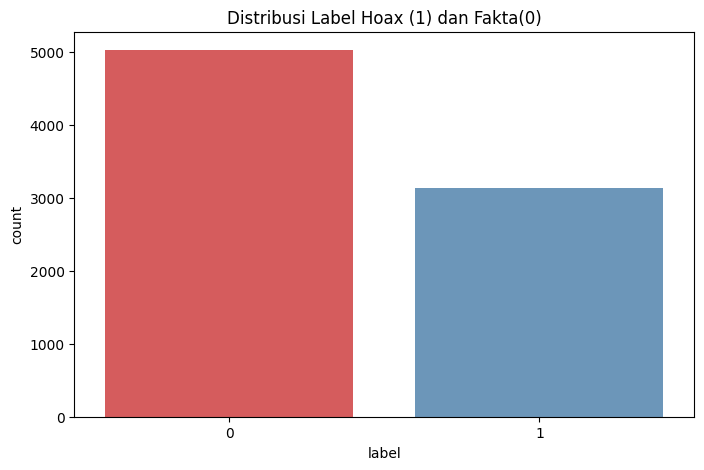

In [32]:
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribusi Label Hoax (1) dan Fakta(0)')
print(df.label.value_counts())

#Data Splitting

In [35]:
X = df['cleaned']
y = df['label']

In [41]:
X_val.shape

(2447,)

In [43]:
#split the train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, stratify=y_val, random_state=SEED)

#Tokenisasi Keras

In [44]:
# Tokenization
k_tokenizer = Tokenizer()
k_tokenizer.fit_on_texts(X)

In [45]:
def sequencing_text(texts):
    x = k_tokenizer.texts_to_sequences(texts)
    x = pad_sequences(x, padding='post', maxlen=MAX_LEN)
    return x

In [46]:
X_train_pad = sequencing_text(X_train)
X_val_pad = sequencing_text(X_val)
X_test_pad = sequencing_text(X_test)

y_train_cat = to_categorical(y_train, num_classes = 2)
y_val_cat = to_categorical(y_val, num_classes = 2)
y_test_cat = to_categorical(y_test, num_classes = 2)

print("Shape of train data tensor ['text']:", X_train_pad.shape)
print("Shape of val data tensor ['text']:", X_val_pad.shape)
print("Shape of test data tensor ['text']:", X_test_pad.shape)
print("Shape of train data tensor ['label']:", y_train_cat.shape)
print("Shape of val data tensor ['label']:", y_val_cat.shape)
print("Shape of test data tensor ['label']:", y_test_cat.shape)

Shape of train data tensor ['text']: (5707, 200)
Shape of val data tensor ['text']: (1223, 200)
Shape of test data tensor ['text']: (1224, 200)
Shape of train data tensor ['label']: (5707, 2)
Shape of val data tensor ['label']: (1223, 2)
Shape of test data tensor ['label']: (1224, 2)


#Embedding dengan GloVe

In [47]:
# determine vocab data used
vocab = len(k_tokenizer.word_index) + 1
vocab

35089

In [57]:
#LOAD GLOVE EMBEDDING
glove_path = '/kaggle/working/glove.6B.300d.txt'
glove_embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = embedding

In [58]:
# this function creates a normalized vector for the whole sentence
print('Terdapat %s word vectors.' % len(glove_embeddings_index))

Terdapat 400000 word vectors.


In [59]:
embedding_matrix = np.zeros((vocab, 300))
for word, i in k_tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [60]:
embedding_matrix.shape

(35089, 300)

In [61]:
EMB_SHAPE = embedding_matrix.shape[1]
EMB_SHAPE

300

#Load Model dan Tokenizer IndoBERT

In [62]:
#DEFINE INDOBERT MODEL
tokenizer = AlbertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p1')
bert = TFAutoModel.from_pretrained('indobenchmark/indobert-lite-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


tf_model.h5:   0%|          | 0.00/63.1M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-lite-base-p1 were not used when initializing TFAlbertModel: ['predictions', 'sop_classifier']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at indobenchmark/indobert-lite-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


#Tokenisasi dengan IndoBERT

In [63]:
X_train_seq = tokenizer(
                text = list(X_train),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = 'max_length',
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )

X_val_seq = tokenizer(
                text = list(X_val),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = 'max_length',
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )

X_test_seq = tokenizer(
                text = list(X_test),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = 'max_length',
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )

In [64]:
input_ids_train = X_train_seq['input_ids']
attention_mask_train = X_train_seq['attention_mask']
input_ids_val = X_val_seq['input_ids']
attention_mask_val = X_val_seq['attention_mask']
input_ids_test = X_test_seq['input_ids']
attention_mask_test = X_test_seq['attention_mask']

# Arsitektur Model

## Fungsi Attention Layer dengan GeLU

In [65]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        context = 0.5 * context * (1 + tf.math.erf(context / tf.math.sqrt(2.0))) #GELU Function
        return context

## Pembuatan Arsitektur Model

### Pembuatan Embedding Layer dengan Pembobotan GloVe

In [66]:
embedding_layer = Embedding(vocab,
                            EMB_SHAPE,
                            input_length = MAX_LEN,
                            trainable = False
                           )
embedding_layer.build((1, ))
embedding_layer.set_weights([embedding_matrix])

### Setting Input Model

In [67]:
input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')
input_text = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_text')

### Skenario 3 (Bi-LSTM + Attention + IndoBERT + GloVe)

In [68]:
#build bert model
bemo = bert([input_ids, input_mask])[0]
bid_1 = Bidirectional(LSTM(128, return_sequences=True))(bemo)
att_1 = attention()(bid_1)
att_1 = LayerNormalization()(att_1)

#build embedding model
embedding = embedding_layer(input_text)
bid_2 = Bidirectional(LSTM(128, return_sequences = True))(embedding)
att_2 = attention()(bid_2)
att_2 = LayerNormalization()(att_2)

#Concatenate layers
att = Concatenate()([att_1, att_2])

#Final LayersA
out = Dense(256, activation='relu')(att)
out = BatchNormalization()(out)
out = Dense(128, activation='relu')(out)
out = BatchNormalization()(out)
out = Dense(64, activation='relu')(out)
out = BatchNormalization()(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs=[input_ids, input_mask, input_text], outputs=out)

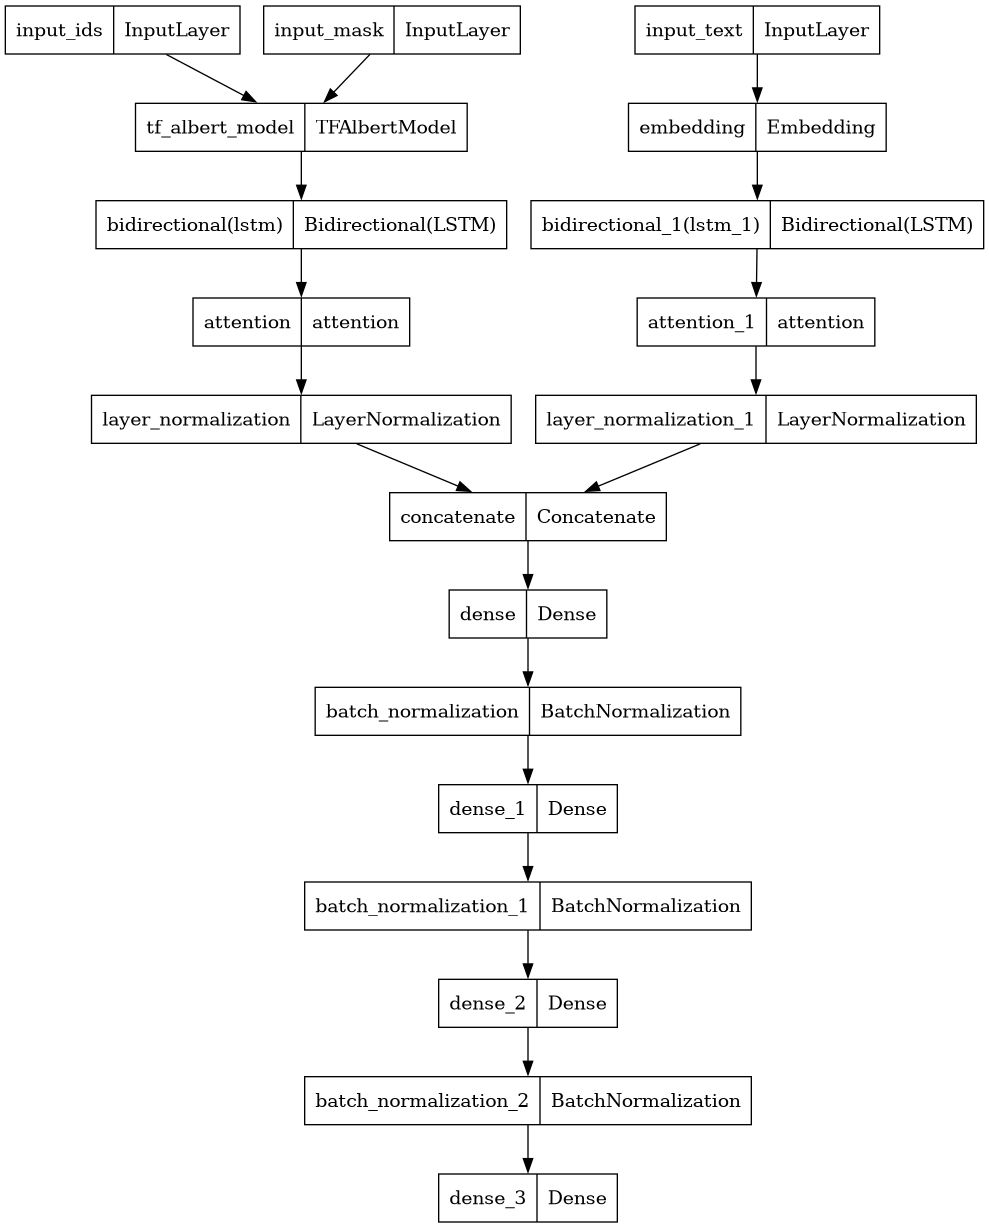

In [69]:
#model plot
tf.keras.utils.plot_model(model)

In [70]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 input_mask (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 input_text (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 tf_albert_model (TFAlbertM  TFBaseModelOutputWithPooli   1168358   ['input_ids[0][0]',           
 odel)                       ng(last_hidden_state=(None   4          'input_mask[0][0]']      

In [71]:
#define optimizer
optimizer = AdamW(learning_rate=1e-5)

In [72]:
#complile the model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [73]:
history = model.fit([input_ids_train, attention_mask_train, X_train_pad],
                    y_train,
                    epochs=20,
                    validation_data=([input_ids_val, attention_mask_val, X_val_pad], y_val),
                    batch_size = 32,
                    verbose=1,
                   )

Epoch 1/20
179/179 [==============================] - 176s 822ms/step - loss: 0.2958 - accuracy: 0.8861 - val_loss: 0.2177 - val_accuracy: 0.9534
Epoch 2/20
179/179 [==============================] - 143s 797ms/step - loss: 0.1284 - accuracy: 0.9620 - val_loss: 0.1588 - val_accuracy: 0.9395
Epoch 3/20
179/179 [==============================] - 143s 797ms/step - loss: 0.0905 - accuracy: 0.9763 - val_loss: 0.1040 - val_accuracy: 0.9681
Epoch 4/20
179/179 [==============================] - 143s 797ms/step - loss: 0.0594 - accuracy: 0.9865 - val_loss: 0.0788 - val_accuracy: 0.9738
Epoch 5/20
179/179 [==============================] - 142s 796ms/step - loss: 0.0476 - accuracy: 0.9904 - val_loss: 0.0748 - val_accuracy: 0.9796
Epoch 6/20
179/179 [==============================] - 142s 796ms/step - loss: 0.0362 - accuracy: 0.9932 - val_loss: 0.0781 - val_accuracy: 0.9771
Epoch 7/20
179/179 [==============================] - 142s 796ms/step - loss: 0.0254 - accuracy: 0.9965 - val_loss: 0.0797 -

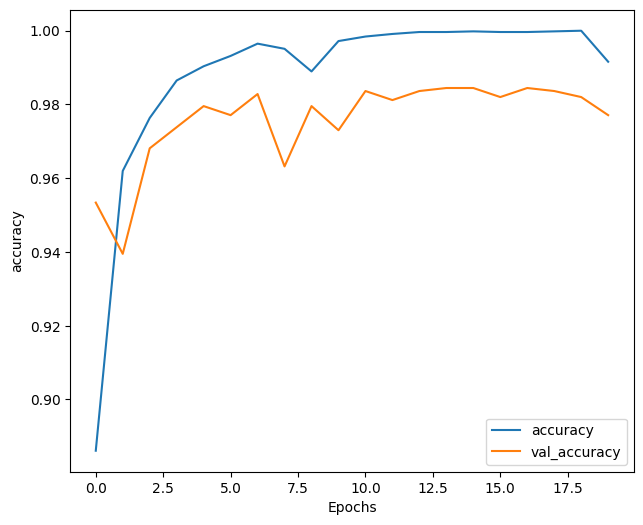

In [74]:
#plot the train/validation loss and accuracy
def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

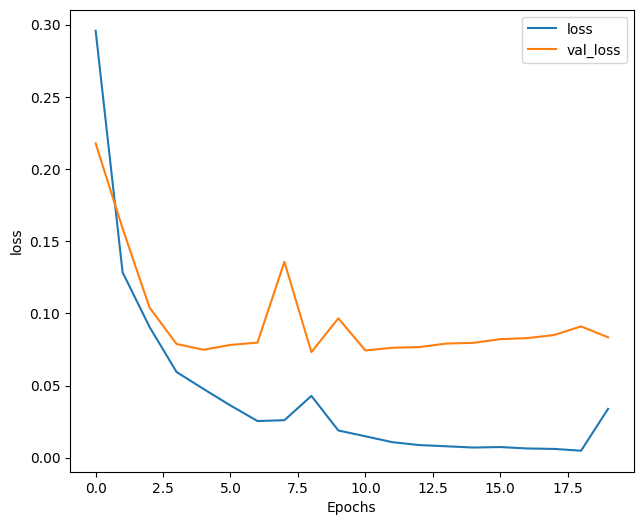

In [75]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [76]:
results = model.evaluate([input_ids_test, attention_mask_test, X_test_pad], y_test, batch_size = 32)
print(model.metrics_names)
print(results)

39/39 [==============================] - 11s 269ms/step - loss: 0.1052 - accuracy: 0.9706
['loss', 'accuracy']
[0.10518859326839447, 0.970588207244873]


In [77]:
#predict the test set labels
y_pred =  np.where(model.predict({'input_ids' : input_ids_test,'input_mask' : attention_mask_test, 'input_text' : X_test_pad}) >=0.5,1,0)

39/39 [==============================] - 15s 266ms/step


In [78]:
# print evaluating model
print('loss : ', results[0])
print('accuracy : ', accuracy_score(y_test, y_pred))
print('precision : ', precision_score(y_test, y_pred))
print('recall : ', recall_score(y_test, y_pred))
print('f1 : ', f1_score(y_test, y_pred))

loss :  0.10518859326839447
accuracy :  0.9705882352941176
precision :  0.9696969696969697
recall :  0.9531914893617022
f1 :  0.9613733905579399


In [79]:
## print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       754
           1       0.97      0.95      0.96       470

    accuracy                           0.97      1224
   macro avg       0.97      0.97      0.97      1224
weighted avg       0.97      0.97      0.97      1224



Text(70.72222222222221, 0.5, 'Real Labels')

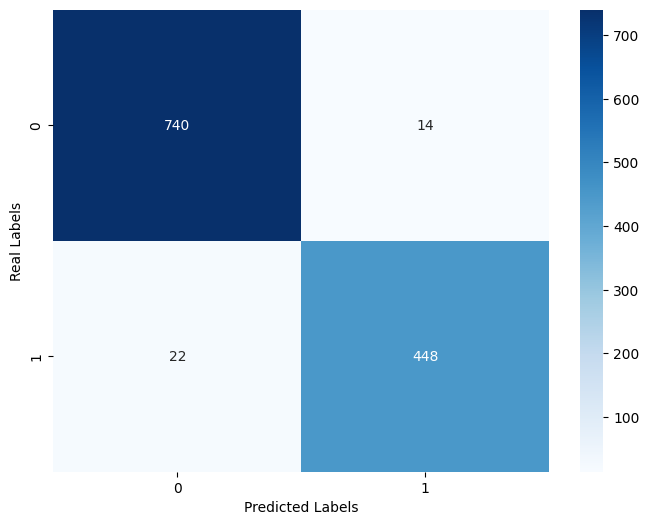

In [80]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [ ]:
# model.save('model.h5')

In [82]:
model.save('model_indobert.keras')

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
